In [20]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import nltk
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [22]:
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ki_shari\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
# Define the preprocessing functions
def remove_special_chars(text):
    # Remove special characters and punctuation
    clean_text = re.sub(r'[^\w\s]', '', text)
    return clean_text

def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]

    return lemmatized_tokens

In [24]:
df = pd.read_csv(r'C:\Users\ki_shari\Downloads\DFF.csv', encoding='latin-1')

In [25]:
df.head(5)

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,ORIGINAL_TEXT,normalized_scores,incon
0,1,1,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",0.726538,Medium
1,2,1,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.723638,Medium
2,3,1,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,0.483963,Low
3,4,1,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,0.726538,Medium
4,5,1,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.726538,Medium


In [26]:
print(df['ORIGINAL_TEXT'])

0        When least you think so, this product will sav...
1        Lithium batteries are something new introduced...
2        I purchased this swing for my baby. She is 6 m...
3        I was looking for an inexpensive desk calcolat...
4        I only use it twice a week and the results are...
                               ...                        
20995    I bought these for work.  I have high arches, ...
20996    Crocs are one of only two brands of shoes that...
20997    I love moccasins  This fit like it was custom ...
20998    I wish these were a little more durable. I got...
20999    I've been looking for a replacement for my bel...
Name: ORIGINAL_TEXT, Length: 21000, dtype: object


In [27]:
df.loc[df["LABEL"] == "__label1__", "LABEL"] = 1
df.loc[df["LABEL"] == "__label2__", "LABEL"] = 0
df['LABEL']=pd.to_numeric(df['LABEL'])

In [28]:
# Apply the preprocessing steps
df['ORIGINAL_TEXT'] = df['ORIGINAL_TEXT'].apply(remove_special_chars)
df['ORIGINAL_TEXT'] = df['ORIGINAL_TEXT'].apply(preprocess_text)

<Axes: >

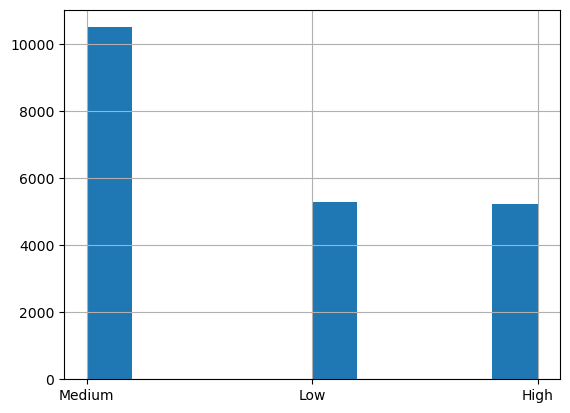

In [29]:
df['incon'].hist()

In [30]:
print(df['incon'])

0        Medium
1        Medium
2           Low
3        Medium
4        Medium
          ...  
20995    Medium
20996    Medium
20997      High
20998    Medium
20999    Medium
Name: incon, Length: 21000, dtype: object


In [31]:
# Convert the 'incon' column to numerical values
incon_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['incon_encoded'] = df['incon'].map(incon_mapping)

# Prepare the target labels
labels = np.array(df['LABEL'].tolist())

In [32]:
print(df['ORIGINAL_TEXT'])

0        [least, think, product, save, day, keep, aroun...
1        [lithium, batteri, someth, new, introduc, mark...
2        [purchas, swing, babi, 6, month, pretti, much,...
3        [look, inexpens, desk, calcolatur, work, every...
4        [use, twice, week, result, great, use, teeth, ...
                               ...                        
20995    [bought, work, high, arch, use, arch, support,...
20996    [croc, one, two, brand, shoe, foot, day, work,...
20997    [love, moccasin, fit, like, custom, made, mebr...
20998    [wish, littl, durabl, got, caught, bolt, cross...
20999    [ive, look, replac, belov, kso, trek, own, two...
Name: ORIGINAL_TEXT, Length: 21000, dtype: object


In [33]:
# Split into features and target
X = df['ORIGINAL_TEXT'].values
y = df['LABEL'].values
incon_encoded = df['incon_encoded'].values
normalized_scores = df['normalized_scores'].values


# Convert labels to binary format (0, 1)
le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

# Define the CNN model using functional API
def create_cnn_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))
    
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv_layer = Conv1D(128, 5, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    
    concatenated = Concatenate()([pooling_layer, input_incon])
    dense_layer = Dense(64, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense_layer)
    
    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

In [34]:
num_folds = 5
seed = 42

# Define the parameters for tokenization and padding
max_features = 10000  # Maximum number of words to keep based on word frequency
maxlen = 100  # Maximum length of each review (truncate or pad with zeros)

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)

# Pad the sequences
X_padded = pad_sequences(X_tokenized, maxlen=maxlen)

# Load GloVe embeddings
embedding_dim = 300
embedding_path = 'C:\\Users\\ki_shari\\Downloads\\glove.6B.300d.txt\\glove.6B.300d.txt'

embedding_matrix = np.zeros((max_features, embedding_dim))
with open(embedding_path, encoding='utf-8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        if word in tokenizer.word_index and tokenizer.word_index[word] < max_features:
            embedding_matrix[tokenizer.word_index[word]] = np.fromstring(vec, sep=' ')

In [31]:
# Define the K-fold cross-validation
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded):
    # Split the data into train and test sets
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    incon_train, incon_test = incon_encoded[train_index], incon_encoded[test_index]

    # Create the CNN model
    model = create_cnn_model(max_features, embedding_dim, maxlen)

    # Set the pre-trained GloVe embedding weights
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Train the model
    model.fit([X_train, incon_train], y_train, batch_size=64, epochs=5, verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred = (y_pred > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))
    
print('Average Accuracy:', np.mean(acc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average AUC:', np.mean(auc_scores))

132/132 [==============================] - 2s 11ms/step
Average Accuracy: 0.5919047619047619
Average F1 Score: 0.6020454898541157
Average Recall: 0.6242347366406897
Average Precision: 0.5875667851107595
Average AUC: 0.5918093540583447


In [34]:
# Define the K-fold cross-validation
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded):
    # Split the data into train and test sets
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    incon_train, incon_test = incon_encoded[train_index], incon_encoded[test_index]

    # Create the CNN model
    model = create_cnn_model(max_features, embedding_dim, maxlen)

    # Set the pre-trained GloVe embedding weights
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Train the model
    model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=0)

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred = (y_pred > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))
    
print('Average Accuracy:', np.mean(acc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average AUC:', np.mean(auc_scores))

132/132 [==============================] - 2s 11ms/step
Average Accuracy: 0.5838571428571429
Average F1 Score: 0.5623057883506644
Average Recall: 0.5424674321423447
Average Precision: 0.594764126510211
Average AUC: 0.584610810731433


In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the K-fold cross-validation
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded):
    # Split the data into train and test sets
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    incon_train, incon_test = incon_encoded[train_index], incon_encoded[test_index]

    # Create the CNN model
    model = create_cnn_model(max_features, embedding_dim, maxlen)

    # Set the pre-trained GloVe embedding weights
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)

    # Train the model
    model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=0, callbacks=[reduce_lr])

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred = (y_pred > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))

print('Average Accuracy:', np.mean(acc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average AUC:', np.mean(auc_scores))

132/132 [==============================] - 2s 11ms/step
Average Accuracy: 0.5872857142857143
Average F1 Score: 0.5836489121881063
Average Recall: 0.5906259239837212
Average Precision: 0.5900629373893633
Average AUC: 0.5865781534161215


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate

def create_cnn_model(vocab_size, embedding_dim, maxlen):
    input_text = Input(shape=(maxlen,))
    input_incon = Input(shape=(1,))
    
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=maxlen)(input_text)
    conv1 = Conv1D(128, 3, activation='relu')(embedding_layer)
    conv2 = Conv1D(128, 4, activation='relu')(embedding_layer)
    conv3 = Conv1D(128, 5, activation='relu')(embedding_layer)
    
    pooling1 = GlobalMaxPooling1D()(conv1)
    pooling2 = GlobalMaxPooling1D()(conv2)
    pooling3 = GlobalMaxPooling1D()(conv3)
    
    concatenated = Concatenate()([pooling1, pooling2, pooling3, input_incon])
    
    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)
    
    output = Dense(1, activation='sigmoid')(dropout1)
    
    model = Model(inputs=[input_text, input_incon], outputs=output)
    return model

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_folds = 5
seed = 42

# Define the K-fold cross-validation
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded):
    # Split the data into train and test sets
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    incon_train, incon_test = incon_encoded[train_index], incon_encoded[test_index]

    # Create the CNN model
    model = create_cnn_model(max_features, embedding_dim, maxlen)

    # Set the pre-trained GloVe embedding weights
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)

    # Train the model
    model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=0, callbacks=[reduce_lr], validation_data=([X_test, incon_test], y_test))

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred = (y_pred > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))

print('Average Accuracy:', np.mean(acc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average AUC:', np.mean(auc_scores))

132/132 [==============================] - 4s 27ms/step
Average Accuracy: 0.6002380952380952
Average F1 Score: 0.5935211196266797
Average Recall: 0.586206652151836
Average Precision: 0.6031044037394577
Average AUC: 0.6000346717829196


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_folds = 5
seed = 42

# Define the K-fold cross-validation
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

acc_scores = []
f1_scores = []
recall_scores = []
precision_scores = []
auc_scores = []

for train_index, test_index in kf.split(X_padded):
    # Split the data into train and test sets
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]
    incon_train, incon_test = normalized_scores[train_index], normalized_scores[test_index]

    # Create the CNN model
    model = create_cnn_model(max_features, embedding_dim, maxlen)

    # Set the pre-trained GloVe embedding weights
    model.layers[1].set_weights([embedding_matrix])
    model.layers[1].trainable = False

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.0001)

    # Train the model
    model.fit([X_train, incon_train], y_train, batch_size=16, epochs=10, verbose=0, callbacks=[reduce_lr], validation_data=([X_test, incon_test], y_test))

    # Evaluate the model
    y_pred = model.predict([X_test, incon_test])
    y_pred = (y_pred > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_pred))

print('Average Accuracy:', np.mean(acc_scores))
print('Average F1 Score:', np.mean(f1_scores))
print('Average Recall:', np.mean(recall_scores))
print('Average Precision:', np.mean(precision_scores))
print('Average AUC:', np.mean(auc_scores))

132/132 [==============================] - 2s 17ms/step
Average Accuracy: 0.5986190476190476
Average F1 Score: 0.6115946622169777
Average Recall: 0.6440731271941253
Average Precision: 0.5958307155927027
Average AUC: 0.5981979311947639
